In [16]:
import pandas as pd
df = pd.read_csv('predictive_maintenance.csv')

由于这是时间序列数据，首先想到构建RNN模型进行预测
首先FP点很少，针对每个设备绘制折线图，查看每个设备失败的趋势

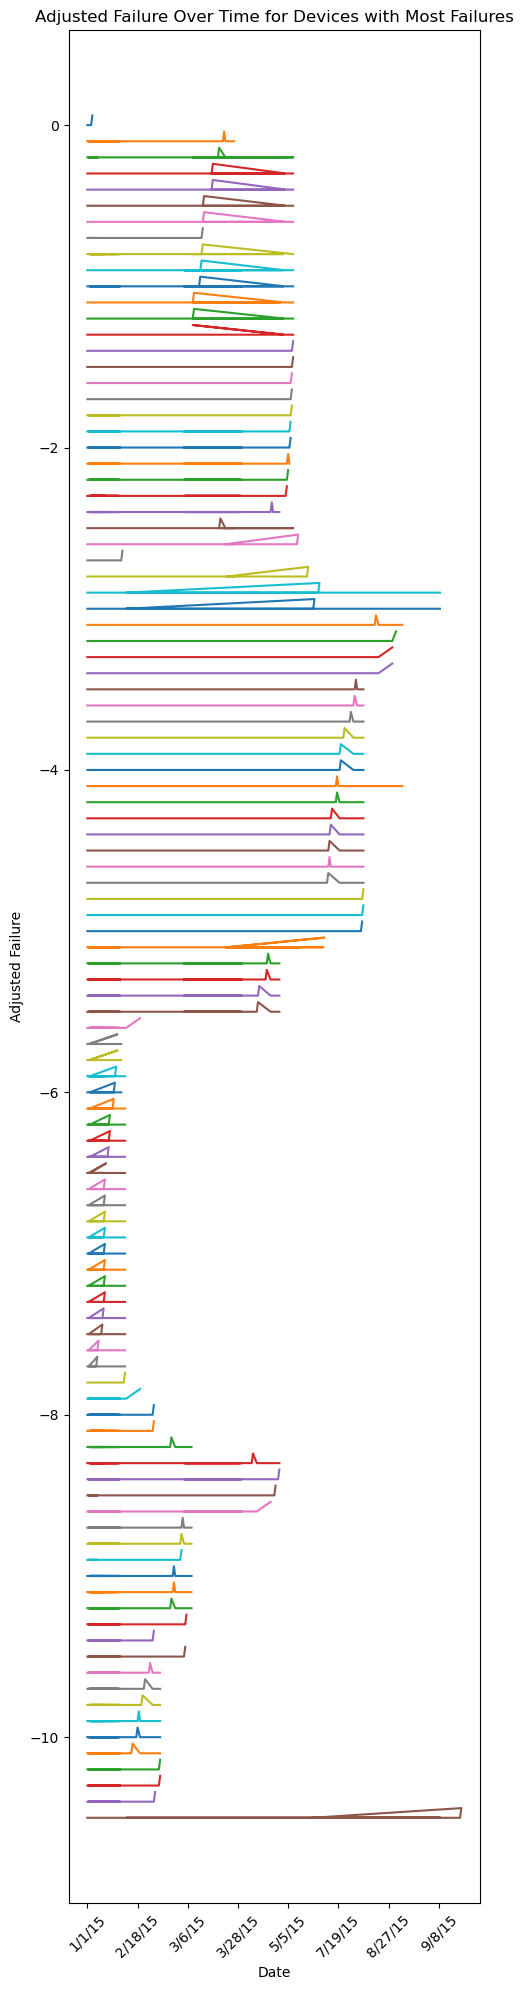

In [17]:
import pandas as pd
import matplotlib.pyplot as plt


df_failure = df[df['failure'] == 1]
devices = df_failure['device'].value_counts().index.tolist()


df_top = df[df['device'].isin(devices)]
df_top = df_top.replace(1,0.06)
plt.figure(figsize=(5, 20))
offset = 0.0  # 初始偏移量
for device in devices:
    df_device = df_top[df_top['device'] == device].sort_values('date')
    plt.plot(df_device['date'], df_device['failure'] - offset, linestyle='-')
    offset += 0.1

# 设置X轴的日期标签数量和格式
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # 只显示10个日期标签
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Adjusted Failure')
plt.title('Adjusted Failure Over Time for Devices with Most Failures')
plt.tight_layout()
plt.show()

In [18]:
# 检查是否有设备failure了两次
failed_devices = df[df['failure'] == 1]['device'].value_counts()
failed_devices = failed_devices[failed_devices > 1].index.tolist()
failed_devices

[]

In [19]:
# 筛选从来没有失败的设备和有失败的设备的信息
device_counts = df['device'].value_counts()

# Devices with failures
devices_with_failures = df[df['failure'] == 1]['device'].unique()
devices_with_failures_count = df[df['device'].isin(devices_with_failures)]['device'].value_counts()
avg_devices_with_failures = devices_with_failures_count.mean()

# Devices without failures
devices_without_failures = device_counts.index.difference(devices_with_failures)
devices_without_failures_count = df[df['device'].isin(devices_without_failures)]['device'].value_counts()
avg_devices_without_failures = devices_without_failures_count.mean()

result_without_failures = pd.DataFrame({
    'Device': devices_without_failures_count.index.tolist() + ['Average'],
    'Count': devices_without_failures_count.values.tolist() + [avg_devices_without_failures]
})

# Append average for devices with failures
result_with_failures = pd.DataFrame({
    'Device': devices_with_failures_count.index.tolist() + ['Average'],
    'Count': devices_with_failures_count.values.tolist() + [avg_devices_with_failures]
})
display(result_with_failures)
result_without_failures

,Device,Count
0,W1F0T0B1,299.000000
1,Z1F14BGY,282.000000
2,S1F0JGJV,278.000000
3,Z1F0MRPJ,230.000000
4,W1F11ZG9,229.000000
...,...,...
102,S1F11MB0,7.000000
103,S1F10E6M,7.000000
104,S1F0CTDN,7.000000
105,S1F0RRB1,5.000000


,Device,Count
0,Z1F0QLC1,304.000000
1,Z1F0KJDS,304.000000
2,Z1F0MA1S,304.000000
3,S1F0E9EP,304.000000
4,S1F0EGMT,304.000000
...,...,...
1059,Z1F0LKBP,5.000000
1060,S1F04KSC,4.000000
1061,W1F0WJFT,3.000000
1062,W1F1DA5ÿ,1.000000


分别查看有损坏情况的设备和没损坏情况的设备的数据量情况，发现平均数集中在100左右。
#### RNN模型架构(LSTM, GRU)
* 模型构想
首先我设想构建N个cell，每一个cell存储一种设备、在时间序列上的点的9个特征信息
由于失败的数量过少，所以在构造数据时默认认为这N个时间戳下设备都没有损坏。

* 输入数据
经过观察发现有损坏的设备的数据特征如下：大多数数据在损坏后就没什么数据了，所以我想只用损坏那天前的所有数据来训练。
因为是二分类问题，所以输入的数据分为两类：
**第一类**是在第N天设备损坏的情况，最后的输出为1；；**第二类**是在第N天设备没有损坏的情况，最后输出为0

* 输入不平衡的问题
由于存在损坏的设备：没有存在损坏的设备的比为1：10 (107:1064)
所以需要一个方法来平衡数据集，我的几个思路
1. 数据增强：对于每个损坏设备构造多个样本
对于第一类设备，可以取损坏当天和前后3天的数据都作为最终输出。且为了过采样，可以从前M天中抽取N天作为样本，这样对于每个设备就能构造出很
2. SMOTE
对于从来没有损坏的设备，如果强行构造损坏的数据点感觉不符合事实
对于有损坏的设备，在状态正常的时间线上构造损坏的数据点感觉也不符合事实
3. 权重调整：给予少数类更高的权重，从而在损失函数中增加对这些样本的惩罚。
4. ...


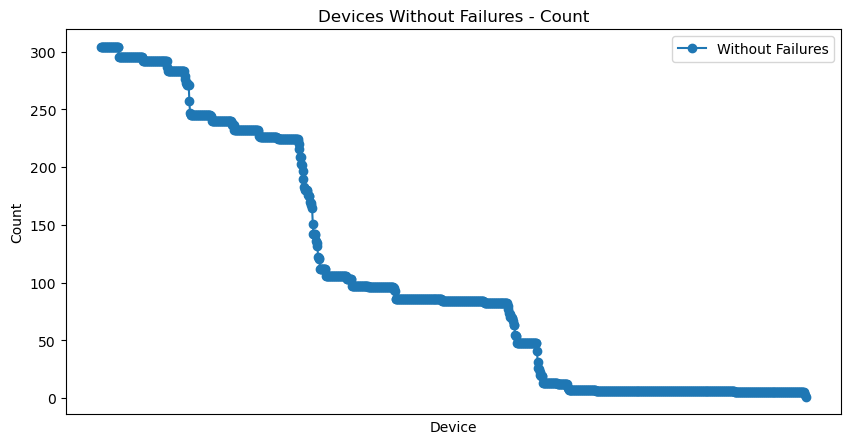

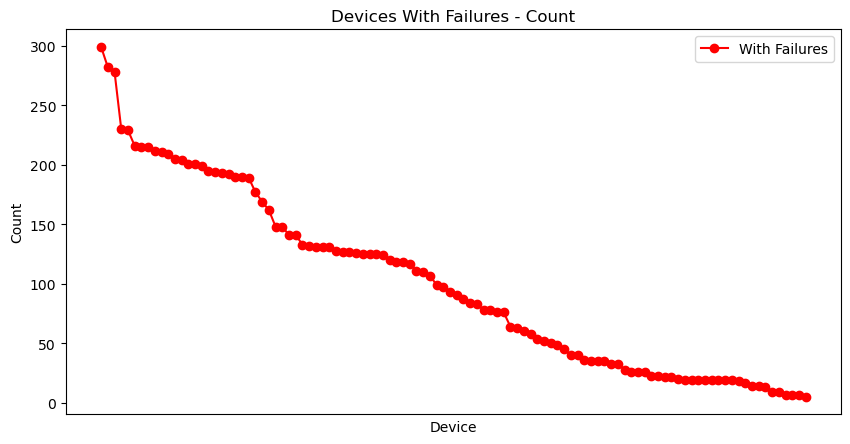

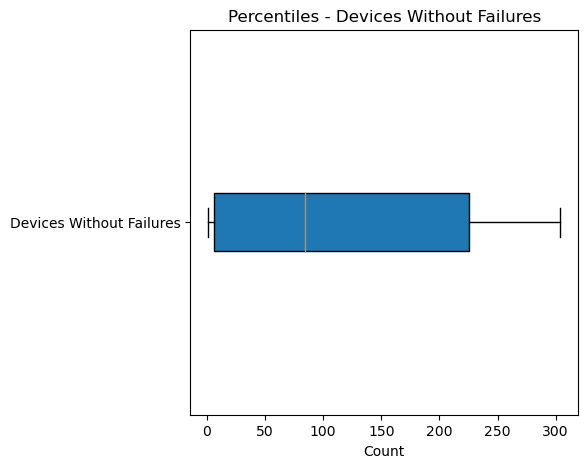

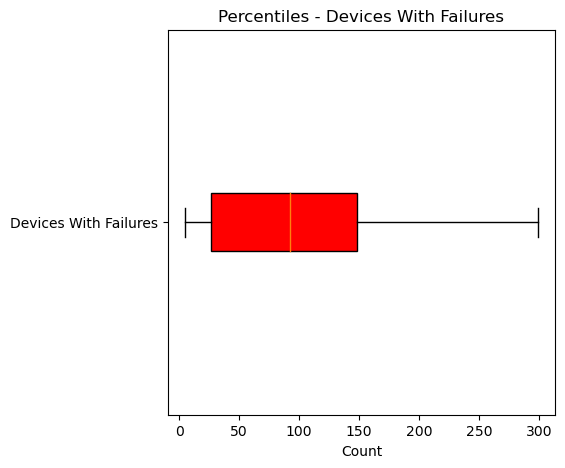

In [20]:
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(result_without_failures['Device'][:-1], result_without_failures['Count'][:-1], marker='o', label='Without Failures')
plt.title('Devices Without Failures - Count')
plt.xlabel('Device')
plt.xticks([])
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Devices with failures
plt.figure(figsize=(10, 5))
plt.plot(result_with_failures['Device'][:-1], result_with_failures['Count'][:-1], marker='o', color='red', label='With Failures')
plt.title('Devices With Failures - Count')
plt.xlabel('Device')
plt.xticks([])
plt.ylabel('Count')
plt.legend()
plt.show()

# Percentile plots
# Without failures
percentiles_without_failures = np.percentile(result_without_failures['Count'][:-1], [25, 50, 75])
plt.figure(figsize=(5, 5))
plt.boxplot(result_without_failures['Count'][:-1], vert=False, patch_artist=True)
plt.title('Percentiles - Devices Without Failures')
plt.yticks([1], ['Devices Without Failures'])
plt.xlabel('Count')
plt.show()

# With failures
percentiles_with_failures = np.percentile(result_with_failures['Count'][:-1], [25, 50, 75])
plt.figure(figsize=(5, 5))
plt.boxplot(result_with_failures['Count'][:-1], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
plt.title('Percentiles - Devices With Failures')
plt.yticks([1], ['Devices With Failures'])
plt.xlabel('Count')
plt.show()

构建一个采样函数，给定一个值n，从0到n随机取m个不同的数字，但是要求离n越近的数字概率越高。比如
n=20 m=5
[ 3 10 18 19 20]
[ 1 13 17 19 20]
权重函数利用$w(x)=e^{\text{scale}\times x}$
不过当x很大时，采样效果仍不理想，故引入强制选择参数

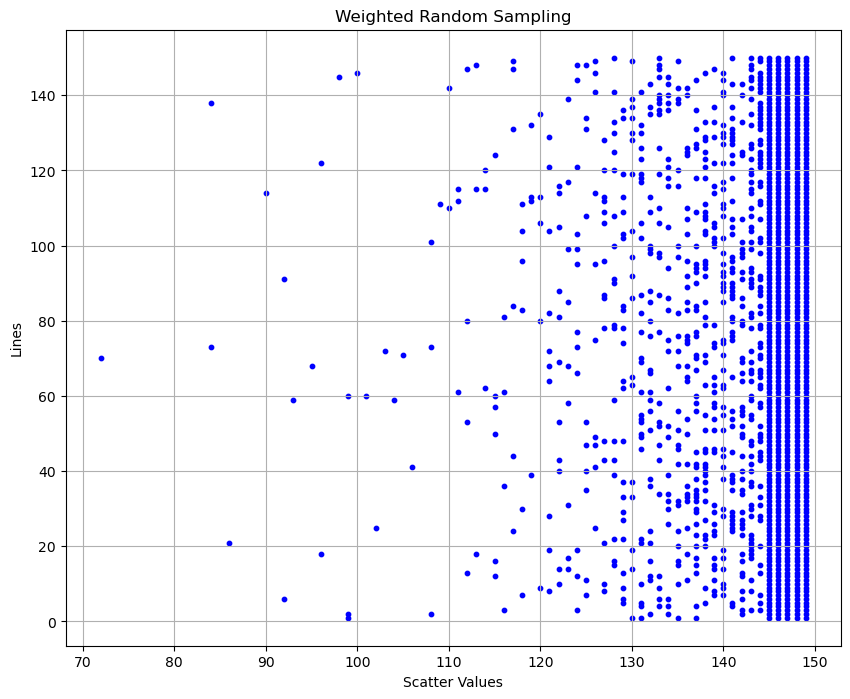

In [21]:
import matplotlib.pyplot as plt

def weighted_random_sampling(n, m, scale=0.2, forced=5):
    # 初始化权重数组，距离n-force越近权重越大
    weights = np.array([np.exp(-scale * abs(i - (n - forced))) for i in range(n-forced)])
    weights /= weights.sum()  # 归一化权重

    # 根据权重进行加权随机选择
    selected_indices = np.random.choice(range(n-forced), size=m-forced, replace=False, p=weights)
    forced_indices = np.arange(n-forced, n)
    selected = np.concatenate((forced_indices, selected_indices))
    selected.sort()
    return selected[-m:]


num_lines = 150
n = 150
m = 10
scale = 0.1
plt.figure(figsize=(10, 8))
for _ in range(num_lines):
    selected = weighted_random_sampling(n, m, scale)
    selected.sort()
    # print(selected)
    plt.scatter(selected, [num_lines - _] * m, marker='o', color='blue',s=10)
plt.xlabel('Scatter Values')
plt.ylabel('Lines')
plt.title('Weighted Random Sampling')
plt.grid(True)
plt.show()

先从start_idx到end_idx之间选取一个最后的索引，再从0到最后的索引之间按照时间顺序选取10个样本点（必须包括最后一个索引），append到samples中。
其中进行的抽样逻辑如下：
如果一共样本数量小于10，那么在抽取所有样本后随机抽取，填充到10个（按照时间顺序），并且抽取$min(C^n_10,5)$，次
如果样本数量大于10，那么抽取$min(C^{10}_N /8 , 100)$次


In [22]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.special import comb
import random
# LSTM模型一共有几个cell
cell_N=10
# 对一件设备于抽取时，有损坏的设备最大抽多少个
failed_max = 100
# 对一件设备于抽取时，没有损坏的设备最大抽多少个
normal_max = 10

df.sort_values(by=['device', 'date'], inplace=True)



def generate_samples(device_df, n_days=2, n_samples=10):
    samples = []
    labels = []
    device_df = device_df.reset_index(drop=True)

    # 这个标志判断这个设备是否有损坏
    flag = len(device_df[device_df['failure'] == 1]['date']) > 0

    if flag :#有损坏
        idx = device_df.index[device_df['failure'] == 1][0]
    else:
        idx = len(device_df)

    start_idx = max(idx - n_days, 0)
    end_idx = min(idx + n_days + 1, len(device_df))
    # 一共有N个样本待抽取
    N = end_idx + 1
    if end_idx + 1 < cell_N:
        num_samples_to_generate = 10 if flag else 5 # 不平衡数据集，如果没损坏就少抽点。。。
    else:
        num_combinations = comb(N, cell_N, exact=True) # C^10_N 个可能性
        ### 抽取规则
        num_samples_to_generate = min(num_combinations // 8, failed_max if flag else normal_max)
    # print(flag, num_samples_to_generate,N)
    for _ in range(num_samples_to_generate):
        final_idx = np.random.randint(start_idx, end_idx)
        if len(device_df)<10:
            selected_indices = np.arange(0, len(device_df))
            fill_indices = np.random.choice(selected_indices, cell_N - len(device_df), replace=True)
            selected_indices = np.concatenate([selected_indices, fill_indices])
            selected_indices.sort()
            # print(selected_indices)
        else:
            # 索引加权，使得离 final_idx 越近的索引对应的权重越大。
            final_idx = 10 if final_idx<10 else final_idx
            selected_indices = weighted_random_sampling(final_idx, cell_N)
            # print(selected_indices,idx)
        # 获取到了一个batch
        samples.append(device_df.iloc[selected_indices][['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric8', 'metric9']].values.tolist())
        labels.append(1 if flag else 0)

    return samples, labels

# 生成样本和标签
samples = []
labels = []
for device, device_df in tqdm(df.groupby('device'),total=len(df.groupby('device'))) :
    device_samples, device_labels = generate_samples(device_df)
    samples.extend(device_samples)
    labels.extend(device_labels)

# 分割数据集
X_train, X_temp, y_train, y_temp = train_test_split(samples, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

100%|██████████| 1169/1169 [00:08<00:00, 132.91it/s]


In [23]:
y_train
indices_true = [index for index, value in enumerate(y_train) if value == 1]
indices_false = [index for index, value in enumerate(y_train) if value == 0]
len(indices_true)/len(indices_false)

1.096549765724833

In [24]:
X_train

[[[116401408, 0, 1, 6, 13, 311027, 0, 0, 1],
  [157383128, 0, 1, 6, 13, 326137, 0, 0, 1],
  [184608040, 0, 1, 6, 13, 327447, 0, 0, 1],
  [229105808, 0, 1, 6, 13, 329971, 0, 0, 1],
  [8746560, 0, 1, 6, 13, 303212, 0, 0, 1],
  [9844264, 0, 1, 6, 13, 331246, 0, 0, 1],
  [228791992, 0, 1, 6, 13, 303212, 0, 0, 1],
  [187337488, 0, 1, 6, 13, 303212, 0, 0, 1],
  [207663744, 0, 1, 6, 13, 303216, 0, 0, 1],
  [137590512, 0, 1, 6, 13, 303232, 0, 0, 1]],
 [[78610984, 0, 0, 0, 12, 251587, 0, 0, 0],
  [230256336, 0, 0, 0, 12, 245239, 0, 0, 0],
  [2311872, 0, 0, 0, 12, 251605, 0, 0, 0],
  [195589992, 0, 0, 0, 12, 256774, 0, 0, 0],
  [119741328, 0, 0, 0, 12, 256774, 0, 0, 0],
  [91449632, 0, 0, 0, 12, 256774, 0, 0, 0],
  [54676168, 0, 0, 0, 12, 256774, 0, 0, 0],
  [224932352, 0, 0, 0, 12, 256774, 0, 0, 0],
  [206373016, 0, 0, 0, 12, 256774, 0, 0, 0],
  [193511720, 0, 0, 0, 12, 256774, 0, 0, 0]],
 [[175665136, 0, 0, 0, 90, 246618, 0, 0, 0],
  [240437736, 0, 0, 0, 90, 246628, 0, 0, 0],
  [96397680, 0, 0

In [25]:
y_train

[0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,


In [26]:
print(len(X_train),len(y_train))
print(len(X_val),len(y_val))
print(len(X_test),len(y_test))

14766 14766
1846 1846
1846 1846


通过pytorch构建tensor
接下来构建LSTM模型进行预测

In [27]:
import torch
import torch.nn as nn
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


mean_train = X_train_tensor.mean(dim=0, keepdim=True)
std_train = X_train_tensor.std(dim=0, keepdim=True) + 1e-6 # To prevent division by zero

mean_val = X_val_tensor.mean(dim=0, keepdim=True)
std_val = X_val_tensor.std(dim=0, keepdim=True) + 1e-6 # To prevent division by zero

mean_test = X_test_tensor.mean(dim=0, keepdim=True)
std_test = X_test_tensor.std(dim=0, keepdim=True) + 1e-6 # To prevent division by zero



X_train_tensor = (X_train_tensor - mean_train) / std_train
X_val_tensor = (X_val_tensor - mean_val) / std_val
X_test_tensor = (X_test_tensor - mean_test) / std_test

LSTM - Epoch 1: Training Loss: 0.4433707594871521, Validation Loss: 0.4420648477971554
LSTM - Epoch 2: Training Loss: 0.3617815375328064, Validation Loss: 0.4013170190155506
LSTM - Epoch 3: Training Loss: 0.2785083055496216, Validation Loss: 0.3298610746860504
LSTM - Epoch 4: Training Loss: 0.2131199687719345, Validation Loss: 0.3506125919520855
LSTM - Epoch 5: Training Loss: 0.2629840075969696, Validation Loss: 0.296192292124033
LSTM - Epoch 6: Training Loss: 0.14668981730937958, Validation Loss: 0.286918630823493
LSTM - Epoch 7: Training Loss: 0.1105334609746933, Validation Loss: 0.2308641616255045
LSTM - Epoch 8: Training Loss: 0.1505955010652542, Validation Loss: 0.17629844695329666
LSTM - Epoch 9: Training Loss: 0.08052326738834381, Validation Loss: 0.13021464366465807
LSTM - Epoch 10: Training Loss: 0.05938909202814102, Validation Loss: 0.12707412615418434
cal:815 61 41 929


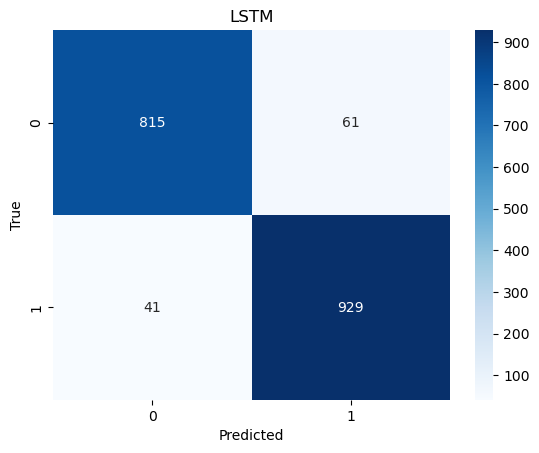

BiLSTM - Epoch 1: Training Loss: 0.5199691653251648, Validation Loss: 0.46533652022480965
BiLSTM - Epoch 2: Training Loss: 0.39232635498046875, Validation Loss: 0.3699673004448414
BiLSTM - Epoch 3: Training Loss: 0.2622150182723999, Validation Loss: 0.34913749620318413
BiLSTM - Epoch 4: Training Loss: 0.19278548657894135, Validation Loss: 0.30050525069236755
BiLSTM - Epoch 5: Training Loss: 0.21586528420448303, Validation Loss: 0.2905653975903988
BiLSTM - Epoch 6: Training Loss: 0.1867515742778778, Validation Loss: 0.25153730623424053
BiLSTM - Epoch 7: Training Loss: 0.13827557861804962, Validation Loss: 0.21666586212813854
BiLSTM - Epoch 8: Training Loss: 0.15303148329257965, Validation Loss: 0.14440380595624447
BiLSTM - Epoch 9: Training Loss: 0.11539056152105331, Validation Loss: 0.1701942840591073
BiLSTM - Epoch 10: Training Loss: 0.08798936754465103, Validation Loss: 0.14217391796410084
cal:796 80 30 940


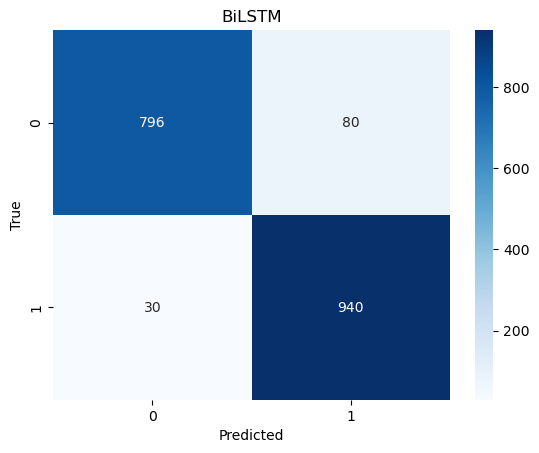

GRU - Epoch 1: Training Loss: 0.5031408667564392, Validation Loss: 0.4861260652542114
GRU - Epoch 2: Training Loss: 0.3885502517223358, Validation Loss: 0.41667652875185013
GRU - Epoch 3: Training Loss: 0.33119744062423706, Validation Loss: 0.29348165169358253
GRU - Epoch 4: Training Loss: 0.2515738904476166, Validation Loss: 0.3141716867685318
GRU - Epoch 5: Training Loss: 0.2864775061607361, Validation Loss: 0.1861940249800682
GRU - Epoch 6: Training Loss: 0.13611666858196259, Validation Loss: 0.15337026212364435
GRU - Epoch 7: Training Loss: 0.12148512899875641, Validation Loss: 0.1253866981714964
GRU - Epoch 8: Training Loss: 0.13146120309829712, Validation Loss: 0.09192991768941283
GRU - Epoch 9: Training Loss: 0.03151106834411621, Validation Loss: 0.1233627088367939
GRU - Epoch 10: Training Loss: 0.01735786162316799, Validation Loss: 0.10277096973732114
cal:844 32 24 946


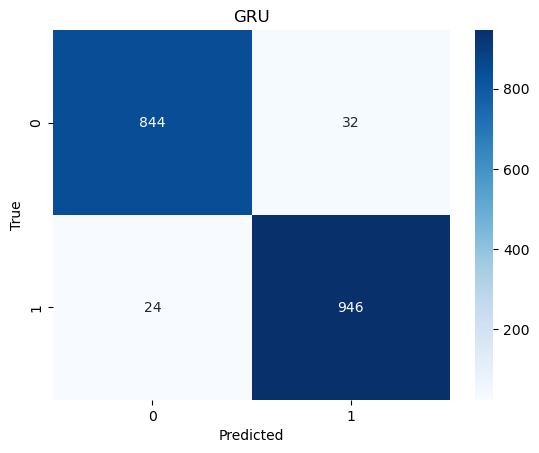

BiGRU - Epoch 1: Training Loss: 0.506630539894104, Validation Loss: 0.535451602190733
BiGRU - Epoch 2: Training Loss: 0.4104236364364624, Validation Loss: 0.415976345539093
BiGRU - Epoch 3: Training Loss: 0.20118685066699982, Validation Loss: 0.3106958903372288
BiGRU - Epoch 4: Training Loss: 0.14481757581233978, Validation Loss: 0.24929256923496723
BiGRU - Epoch 5: Training Loss: 0.20776981115341187, Validation Loss: 0.21995099820196629
BiGRU - Epoch 6: Training Loss: 0.12357214093208313, Validation Loss: 0.19222676381468773
BiGRU - Epoch 7: Training Loss: 0.08274637162685394, Validation Loss: 0.17413314245641232
BiGRU - Epoch 8: Training Loss: 0.07489272207021713, Validation Loss: 0.15088211186230183
BiGRU - Epoch 9: Training Loss: 0.02009848691523075, Validation Loss: 0.10188755393028259
BiGRU - Epoch 10: Training Loss: 0.01466790959239006, Validation Loss: 0.0908525725826621
cal:824 52 22 948


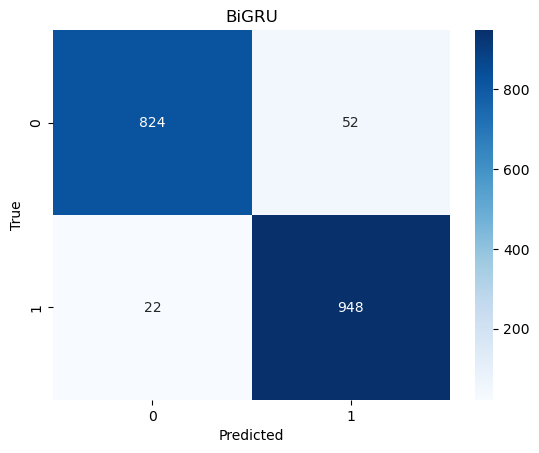

,Model,Accuracy,Precision,Recall,Specificity,F1 Score,ROC AUC
0,LSTM,0.944745,0.938384,0.957732,0.930365,0.947959,0.989213
1,BiLSTM,0.940412,0.921569,0.969072,0.908676,0.944724,0.990360
2,GRU,0.969664,0.967280,0.975258,0.963470,0.971253,0.991071
3,BiGRU,0.959913,0.948000,0.977320,0.940639,0.962437,0.988882


In [28]:
from utils import *
from torch.utils.data import TensorDataset, DataLoader
from models import *


# 参数
input_dim = 9  # 输入特征的维度
hidden_dim = 100  # LSTM的隐藏层维度
layer_dim = 1  # LSTM的层数
output_dim = 1  # 输出维度
learning_rate = 0.01
epochs = 10

# 检查是否有可用的CUDA设备

# 模型实例化并移至GPU
model_LSTM = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
model_LSTM.to(device)
model_BiLSTM = BiLSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
model_BiLSTM.to(device)
model_GRU = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)
model_GRU.to(device)
model_BiGRU = BiGRUModel(input_dim, hidden_dim, layer_dim, output_dim)
model_BiGRU.to(device)

# 损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer_LSTM = torch.optim.Adam(model_LSTM.parameters(), lr=learning_rate)
optimizer_BiLSTM = torch.optim.Adam(model_BiLSTM.parameters(), lr=learning_rate)
optimizer_GRU = torch.optim.Adam(model_GRU.parameters(), lr=learning_rate)
optimizer_BiGRU = torch.optim.Adam(model_BiGRU.parameters(), lr=learning_rate)

models = {
    "LSTM": (model_LSTM, optimizer_LSTM),
    "BiLSTM": (model_BiLSTM, optimizer_BiLSTM),
    "GRU": (model_GRU, optimizer_GRU),
    "BiGRU": (model_BiGRU,optimizer_BiGRU),
}
results = []
# 数据加载器
batch_size = 256
train_dataset = TensorDataset(X_train_tensor.to(device), y_train_tensor.to(device))
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor.to(device), y_val_tensor.to(device))
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)


for model_name, (model, optimizer) in models.items():

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
        # 评估模型...
        model.eval()
        with torch.no_grad():
            total_val_loss = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs.squeeze(), labels.float())
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(val_loader)
            print(f'{model_name} - Epoch {epoch+1}: Training Loss: {loss.item()}, Validation Loss: {avg_val_loss}')

    with torch.no_grad():
        outputs = model(X_test_tensor.to(device))
        predicted = torch.round(torch.sigmoid(outputs.squeeze()))
        accuracy = (predicted == y_test_tensor.to(device)).float().mean().item()
        y_prob = torch.sigmoid(outputs).cpu().numpy()  # 获取概率值
        y_pred = predicted.cpu().numpy()  # 预测的标签
        y_true = y_test_tensor.cpu().numpy()
        precision, recall, specificity, f1, roc_auc = evaluate_model(y_true, y_pred, y_prob)
        plot_confusion_matrix(y_true, y_pred, model_name)
    results.append([model_name, accuracy, precision, recall, specificity, f1, roc_auc])

# 创建DataFrame来展示结果
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "Specificity", "F1 Score", "ROC AUC"])
df_results